In [45]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [46]:
# load standard modules/libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# load special modules/libraries
import os
import warnings
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from collections import Counter
import string
import re
from tqdm  import tqdm

# load pytorch modules/libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader

from sklearn.metrics import f1_score, roc_auc_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
# load dataset
raw_df = pd.read_csv("/content/gdrive/MyDrive/ECE1786_Project/processed_en_dataset.csv")

# Subsample 2500 samples for each class where success == 1 and success == 0
df = pd.concat([
    raw_df[raw_df['success'] == 1].sample(n=2500, random_state=42),
    raw_df[raw_df['success'] == 0].sample(n=2500, random_state=42)
], ignore_index=True)

# Display class distribution
class_distribution = df['success'].value_counts()
print("Class Distribution:")
print(class_distribution)

# process into data and labels
X = df['Description'].values
y = df['success'].values

Class Distribution:
1    2500
0    2500
Name: success, dtype: int64


In [48]:
def preprocess_string(str1):
    # remove all non-word characters excluding number and letters
    str1= re.sub(r"[^\w\s]",'',str1)
    # remove all whitespace with no space
    str1= re.sub(r"\s",'',str1)
    # replace digits with no space
    str1= re.sub(r"\d",'',str1)
    return str1

def preprocess_sentence(sen1):
    word_list=[]
    stop_word = set(stopwords.words("english"))
    for word in sen1.lower().split():
        word = preprocess_string(word)
        if word not in stop_word and word!='':
            word_list.append(word)
    return word_list

def get_stoi(data):
    word_list=[]
    for review in data:
        word_list.extend(preprocess_sentence(review))
    corpus = Counter(word_list)
    print(corpus.get)
    # sorting on the basis of most common words
    corpus_ =sorted(corpus,key= corpus.get,reverse=True)[:1000]
    # creating a dict
    stoi =  {ch:i+1 for i,ch in enumerate(corpus_)}
    return stoi

def tokenize(data, labels, stoi):
    # tokenize
    data_encoded = []
    for review in data:
        data_encoded.append([stoi[word] for word in preprocess_sentence(review)
                                     if word in stoi.keys()])

    labels_encoded = labels

    return np.array(data_encoded), np.array(labels_encoded)

def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review)!=0:
            features[ii, -len(review):] = np.array(review)[:seq_len]

    return features

In [49]:
# Split the dataset into train, valid, and test (60-20-20 split)
train_data, temp_data, train_labels, temp_labels = train_test_split(X, y, test_size=0.4, random_state=42)
valid_data, test_data, valid_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=42)

In [50]:
# Get vocabulary and convert words to indices
stoi = get_stoi(train_data)

# Tokenize the data
train_data_encoded, train_labels_encoded = tokenize(train_data, train_labels, stoi)
valid_data_encoded, valid_labels_encoded = tokenize(valid_data, valid_labels, stoi)
test_data_encoded, test_labels_encoded = tokenize(test_data, test_labels, stoi)

# Padding
seq_len = 500
train_data_padded = padding_(train_data_encoded, seq_len)
valid_data_padded = padding_(valid_data_encoded, seq_len)
test_data_padded = padding_(test_data_encoded, seq_len)

<built-in method get of Counter object at 0x7d0c7a584130>


<ipython-input-48-10f90fb99ae8>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_encoded), np.array(labels_encoded)


In [51]:
# TO BE COMPLETED
# Convert numpy arrays to PyTorch tensors
train_data_tensor = torch.tensor(train_data_padded)
valid_data_tensor = torch.tensor(valid_data_padded)
test_data_tensor = torch.tensor(test_data_padded)

train_labels_tensor = torch.tensor(train_labels_encoded)
valid_labels_tensor = torch.tensor(valid_labels_encoded)
test_labels_tensor = torch.tensor(test_labels_encoded)

# Create TensorDatasets
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
valid_dataset = TensorDataset(valid_data_tensor, valid_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)

# Create DataLoaders
batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Test the DataLoader
for batch in train_loader:
    data_batch, label_batch = batch
    print("Data Batch Shape:", data_batch.shape)
    print("Label Batch Shape:", label_batch.shape)
    break

Data Batch Shape: torch.Size([128, 500])
Label Batch Shape: torch.Size([128])


In [52]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SentimentRNN, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # RNN layer (you can choose between different types of RNNs like LSTM, GRU)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden):
        # Input x is expected to be a LongTensor of shape (batch_size, sequence_length)

        # Embedding layer
        embedded = self.embedding(x)

        # RNN layer
        output, _ = self.rnn(embedded, hidden)

        # Only take the output from the last time step
        output = output[:, -1, :]

        # Fully connected layer
        output = self.fc(output)

        return output, hidden

In [53]:
def get_accuracy(model, data):
    correct, total = 0, 0
    all_preds = []
    all_labels = []
    for inputs, labels in data:
        h = None
        output, _ = model(inputs, h)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]

        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, f1

In [55]:
def train_rnn_network(model, train, valid, num_epochs=20, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    hidden = None ###
    for epoch in range(num_epochs):
        for inputs, labels in train:
            optimizer.zero_grad()
            pred, _ = model(inputs, hidden)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

# Modify the train_rnn_network function to collect F1 scores
def train_rnn_network(model, train, valid, num_epochs=20, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc, train_f1, valid_f1 = [], [], [], [], []
    epochs = []
    hidden = None

    for epoch in range(num_epochs):
        for inputs, labels in train:
            optimizer.zero_grad()
            pred, _ = model(inputs, hidden)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epoch_train_acc, epoch_train_f1 = get_accuracy(model, train_loader)
        epoch_valid_acc, epoch_valid_f1 = get_accuracy(model, valid_loader)

        train_acc.append(epoch_train_acc)
        valid_acc.append(epoch_valid_acc)
        train_f1.append(epoch_train_f1)
        valid_f1.append(epoch_valid_f1)

        epochs.append(epoch)
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f; Train F1 %f; Val F1 %f" % (
              epoch+1, loss, epoch_train_acc, epoch_valid_acc, epoch_train_f1, epoch_valid_f1))

    # Plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_f1, label="Train")
    plt.plot(epochs, valid_f1, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend(loc='best')
    plt.show()

Epoch 1; Loss 0.697570; Train Acc 0.531667; Val Acc 0.525000; Train F1 0.524134; Val F1 0.517230
Epoch 2; Loss 0.668343; Train Acc 0.554000; Val Acc 0.527000; Train F1 0.553992; Val F1 0.527214
Epoch 3; Loss 0.671881; Train Acc 0.569333; Val Acc 0.546000; Train F1 0.569092; Val F1 0.545898
Epoch 4; Loss 0.676462; Train Acc 0.579667; Val Acc 0.550000; Train F1 0.578113; Val F1 0.548096
Epoch 5; Loss 0.678877; Train Acc 0.588667; Val Acc 0.546000; Train F1 0.587425; Val F1 0.544079
Epoch 6; Loss 0.663310; Train Acc 0.596000; Val Acc 0.549000; Train F1 0.594018; Val F1 0.546036
Epoch 7; Loss 0.673516; Train Acc 0.606333; Val Acc 0.539000; Train F1 0.603596; Val F1 0.535133
Epoch 8; Loss 0.645191; Train Acc 0.616000; Val Acc 0.529000; Train F1 0.612851; Val F1 0.523261
Epoch 9; Loss 0.685410; Train Acc 0.618667; Val Acc 0.524000; Train F1 0.615539; Val F1 0.518524
Epoch 10; Loss 0.644762; Train Acc 0.631000; Val Acc 0.536000; Train F1 0.628876; Val F1 0.532708


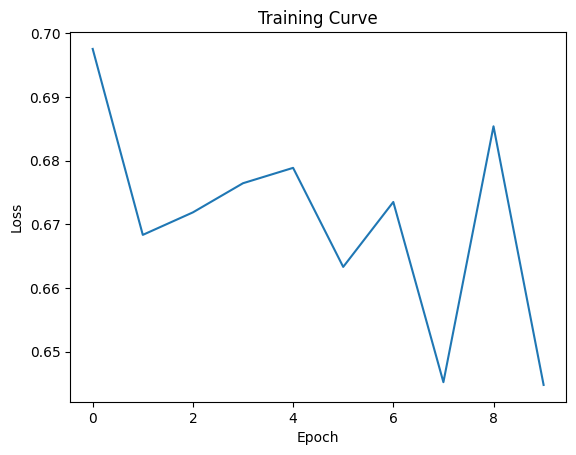

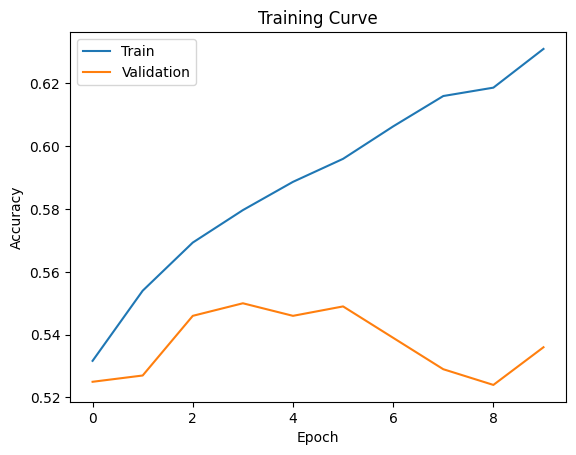

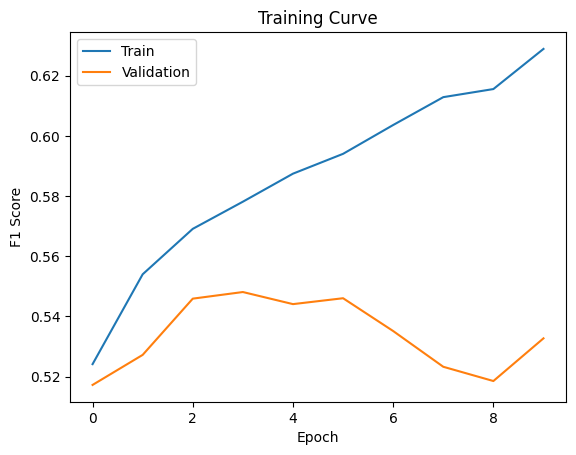

In [56]:
vocab_size = len(stoi) + 1 # Specify your vocabulary size
embed_size = 100 # Specify the embedding size
hidden_size = 64 # Specify the hidden size for the LSTM
output_size =  2# Specify the output size (number of classes)
model = SentimentRNN(vocab_size, embed_size, hidden_size, output_size)

train_rnn_network(model, train_loader, valid_loader, num_epochs=10, learning_rate=2e-4)